<a href="https://colab.research.google.com/github/Mithula05/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Upload and extract the dataset
from google.colab import files
import zipfile

# Upload archive.zip
uploaded = files.upload()

# Extract it
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

print("✅ Dataset extracted successfully!")


Saving archive.zip to archive.zip
✅ Dataset extracted successfully!


In [ ]:
import os
os.listdir("dataset")


['creditcard.csv']

In [ ]:
# Step 2: Import libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("dataset/creditcard.csv")
print("✅ Dataset loaded successfully!")
print(data.head())


✅ Dataset loaded successfully!
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

 

Shape: (284807, 31)

Missing values: 0

Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


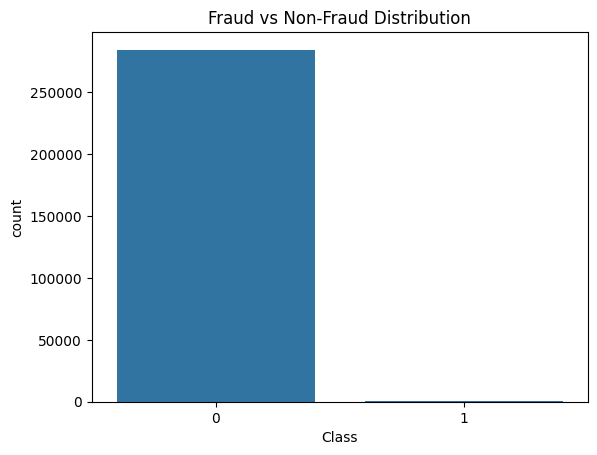

In [ ]:
# Step 3: Basic info
print("Shape:", data.shape)
print("\nMissing values:", data.isnull().sum().sum())
print("\nClass distribution:\n", data['Class'].value_counts())

# Check imbalance visually
sns.countplot(x='Class', data=data)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features & labels
X = data.drop('Class', axis=1)
y = data['Class']

# Normalize 'Amount' and 'Time'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data split done!")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


✅ Data split done!
Train shape: (227845, 30) Test shape: (56962, 30)


In [ ]:
!pip install imbalanced-learn -q
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("✅ After SMOTE:")
print(y_res.value_counts())


✅ After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train
model = LogisticRegression(max_iter=1000)
model.fit(X_res, y_res)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("✅ Model Trained Successfully!")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Model Trained Successfully!

Accuracy: 0.9742635441171307

Confusion Matrix:
 [[55406  1458]
 [    8    90]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [ ]:
def predict_fraud(input_data):
    """
    input_data: dict containing Time, Amount, and V1-V28
    """
    # Convert input to DataFrame
    df = pd.DataFrame([input_data])

    # Normalize same as training
    df[['Time', 'Amount']] = scaler.transform(df[['Time', 'Amount']])

    # Predict
    pred = model.predict(df)[0]
    prob = model.predict_proba(df)[0][1]

    if pred == 1:
        return f"🚨 Fraudulent Transaction Detected! (Risk: {prob:.2%})"
    else:
        return f"✅ Legitimate Transaction (Risk: {prob:.2%})"


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use only Time and Amount
X = data[['Time','Amount']]
y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
import gradio as gr
import pandas as pd
from datetime import datetime

# --- Corrected prediction function ---
def predict_fraud(transaction_type, amount, old_balance, new_balance, transaction_time):
    """
    Only Time and Amount are used by the model. Others are for display.
    """
    try:
        # Convert transaction_time to seconds since start of day
        dt = datetime.strptime(transaction_time, "%Y-%m-%d %H:%M:%S")
        time_in_seconds = dt.hour*3600 + dt.minute*60 + dt.second

        # Prepare DataFrame for the model
        input_df = pd.DataFrame([[time_in_seconds, amount]], columns=['Time','Amount'])
        input_df[['Time','Amount']] = scaler.transform(input_df[['Time','Amount']])

        # Predict
        prob = model.predict_proba(input_df)[0][1]
        verdict = "🚨 Fraudulent Transaction" if prob > 0.5 else "✅ Legitimate Transaction"

        # Prepare transaction summary for display
        summary = f"""
Transaction Type: {transaction_type}
Amount: ₹{amount}
Old Balance: ₹{old_balance}
New Balance: ₹{new_balance}
Transaction Time: {transaction_time}
"""
        return verdict + f"\nRisk Score: {prob*100:.2f}%", summary
    except Exception as e:
        return f"❌ Error: {str(e)}", ""

# --- Build Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("## 💳 Banking Fraud Detection System")
    gr.Markdown("Enter transaction details to check if it's fraudulent or legitimate.")

    with gr.Row():
        with gr.Column():
            txn_type = gr.Dropdown(choices=["Payment","Transfer","Withdrawal","Deposit"], label="Transaction Type")
            amount = gr.Number(label="Transaction Amount (₹)", value=500.0)
            old_balance = gr.Number(label="Old Balance (₹)", value=10000.0)
            new_balance = gr.Number(label="New Balance (₹)", value=9500.0)
            txn_time = gr.Textbox(label="Transaction Time (YYYY-MM-DD HH:MM:SS)", value="2025-10-18 14:30:00")
            predict_btn = gr.Button("🔍 Detect Fraud")

        with gr.Column():
            output_verdict = gr.Textbox(label="Prediction Result", lines=2)
            output_summary = gr.Textbox(label="Transaction Details", lines=6)

    predict_btn.click(
        fn=predict_fraud,
        inputs=[txn_type, amount, old_balance, new_balance, txn_time],
        outputs=[output_verdict, output_summary]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://84cc195b3a86bf9513.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
